# Create UMAP of single cell features

In [1]:
from livecellx.sample_data import tutorial_three_image_sys
from pathlib import Path
from livecellx.core.datasets import LiveCellImageDataset
import glob

dataset_dir_path = Path(
    "../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/"
)

mask_dataset_path = Path("../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg")

mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
time2url = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*_DIC.tif")))))
time2url = {i: path for i, path in enumerate(time2url)}
dic_dataset = LiveCellImageDataset(time2url=time2url, ext="tif")

291 png img file paths loaded: 


In [2]:
from livecellx.core.io_sc import prep_scs_from_mask_dataset
scs = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

100%|██████████| 291/291 [00:18<00:00, 15.91it/s]


In [3]:
from livecellx.trajectory.feature_extractors import compute_haralick_features, compute_skimage_regionprops
from livecellx.preprocess.utils import normalize_img_to_uint8
from livecellx.core.parallel import parallelize
inputs = []
for sc in scs:
    # features = compute_skimage_regionprops(sc, preprocess_img_func=normalize_img_to_uint8, sc_level_normalize=True)
    inputs.append({
        "sc": sc,
        "feature_key": "skimage",
        "preprocess_img_func": normalize_img_to_uint8,
        "sc_level_normalize": True,
    })

def compute_skimage_regionprops_wrapper(**input):
    sc = input["sc"]
    compute_skimage_regionprops(**input)
    return sc
scs = parallelize(compute_skimage_regionprops_wrapper, inputs)

100%|██████████| 6605/6605 [04:13<00:00, 26.06it/s]


In [4]:
def create_sc_table(scs, normalize_features=True, drop_time=True):
    import pandas as pd
    import numpy as np
    df = pd.DataFrame([sc.get_feature_pd_series() for sc in scs])
    if normalize_features:
        for col in df.columns:
            df[col] = (df[col] - df[col].mean())
            col_std = df[col].std()
            if col_std != 0 and not np.isnan(col_std):
                df[col] /= col_std
    # remove column t from df
    if drop_time:
        df.drop("t", axis=1, inplace=True)
    return df

sc_feature_table = create_sc_table(scs)
sc_feature_table[:2]

,skimage_area,skimage_area_bbox,skimage_area_convex,skimage_area_filled,skimage_axis_major_length,skimage_axis_minor_length,skimage_centroid-0,skimage_centroid-1,skimage_centroid_local-0,skimage_centroid_local-1,...,skimage_moments_weighted_normalized-2-2,skimage_moments_weighted_normalized-2-3,skimage_moments_weighted_normalized-3-0,skimage_moments_weighted_normalized-3-1,skimage_moments_weighted_normalized-3-2,skimage_moments_weighted_normalized-3-3,skimage_orientation,skimage_perimeter,skimage_perimeter_crofton,skimage_solidity
0,-0.509338,-0.462826,-0.443450,-0.509338,-0.756158,-0.328665,-0.534969,-0.723864,-0.534969,-0.723864,...,-0.315010,0.164744,-0.037891,-0.539973,-0.061965,-0.325733,-0.913183,-0.584333,-0.585062,0.142696
1,-0.764452,-0.620623,-0.647537,-0.764452,-1.019299,-1.266440,-0.952863,-1.153251,-0.952863,-1.153251,...,-0.179977,-0.260524,0.017620,0.034351,-0.219412,-0.152237,0.231253,-1.029229,-1.027540,0.215172


## Normalize features

## Perform UMAP on features

In [5]:
!pip install umap-learn

In [6]:
import umap
reducer = umap.UMAP()

In [7]:
# check if any columns are all NaN
sc_feature_table = sc_feature_table.dropna(axis=1, how="all")

In [8]:
embedding = reducer.fit_transform(sc_feature_table)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
embedding.shape

(6605, 2)

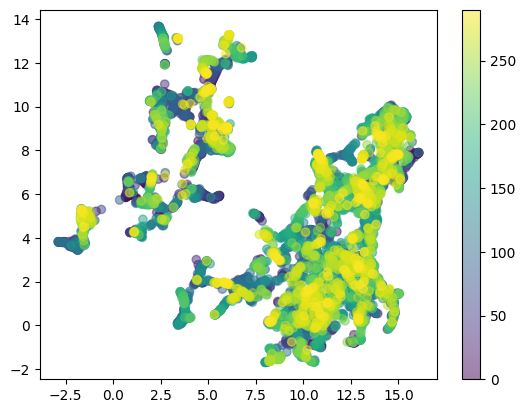

In [10]:
import matplotlib.pyplot as plt
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sc.timeframe for sc in scs],
    alpha=0.5,
)
# add colorbar
plt.colorbar()

In [11]:
# unnormalized_img_features = create_sc_table(scs, normalize_features=False)
# # drop na
# unnormalized_img_features = unnormalized_img_features.dropna(axis=1, how="all")
# reducer = umap.UMAP()
# unnormalized_embedding = reducer.fit_transform(unnormalized_img_features)
# plt.scatter(
#     unnormalized_embedding[:, 0],
#     unnormalized_embedding[:, 1],
#     c=[sc.timeframe for sc in scs],
# )

In [12]:
# list(unnormalized_img_features.keys())